# Testing Temperature Coefficient for the re-weighted Boltzmann Search Strategy  in Thompson Sampling
The Boltzmann distribution contains a temperature term that is used to adjust the distribution to be either narrow or wide. A narrow distribution means that the sampling will be more greedy and a wide distribution means that the sampling will be more uniform. 

In [14]:
# imports
import sys
import os
from tqdm.auto import tqdm
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import json
import copy

In [2]:
project_root = '/Users/aakankschitnandkeolyar/Desktop/PRISMS'
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
from PRISMS.library_analysis.library_analysis_utils import compile_product_scores, compile_product_smiles

In [4]:
from PRISMS.thompson_sampling.ts_main import *

In [5]:
def read_smi_file(file_path):
    """
    Read a .smi file and create a dictionary with building block codes as keys and SMILES as items.
    
    :param file_path: The path to the .smi file.
    :return: A dictionary with building block codes as keys and SMILES as items.
    """
    building_block_dict = {}
    
    with open(file_path, 'r') as file:
        for line in file:
            smiles, code = line.strip().split()
            building_block_dict[code] = smiles
    
    return building_block_dict

In [6]:
def get_top_building_blocks(top_products_df, top_n, Maximize=False):
    """
    Extract the top 20 building blocks for each position from the top N products.
    
    :param Maximize: Sort the building blocks in descending order. If larger values are better scores.
    :param top_products_df: Polars DataFrame containing product codes.
    :param top_n: Number of top products to consider.
    :return: A tuple of lists containing the top 20 building blocks for each position.
    """
    # Get the top N products
    if isinstance(top_products_df, pd.DataFrame):
        top_products_df = top_products_df.sort_values(by="Scores", ascending=Maximize)
    elif isinstance(top_products_df, pl.DataFrame):
        top_products_df = top_products_df.sort("Scores", descending=Maximize)
    else:
        raise TypeError("Input must be either a pandas DataFrame or a polars DataFrame")

    top_n_df = top_products_df.head(top_n)
    
    # Extract the product codes as a list
    product_codes = top_n_df["Product_Code"].to_list()

    # Initialize counters for each position
    position_counters = []

    # Iterate through the product codes
    for product_code in product_codes:
        building_blocks = product_code.split("_")  # Split the product code by "_"
        # Ensure the position_counters list is large enough to handle all positions
        while len(position_counters) < len(building_blocks):
            position_counters.append(Counter())
        # Update the counters for each position
        for i, block in enumerate(building_blocks):
            position_counters[i][block] += 1

    # Collect the top 20 building blocks for each position
    top_20_building_blocks = []
    for counter in position_counters:
        top_20_building_blocks.append([block for block, _ in counter.most_common(20)])
    
    return tuple(top_20_building_blocks)

In [30]:
def compile_TS_product_scores(reference_df, ts_df_list_1, ts_df_list_2, categories_list):
    """
    Compile product scores from docking and Thompson Sampling runs.
    
    Args:
        product_scores_df (pd.DataFrame): DataFrame containing product scores from docking.
        ts_sampling_1_df (pd.DataFrame): DataFrame containing results from first Thompson Sampling run.
        ts_sampling_2_df (pd.DataFrame): DataFrame containing results from second Thompson Sampling run.
    """
    # Clean up brute force docking scores
    reference_df = reference_df.to_pandas() # Convert the polars dataframe to a pandas dataframe
    reference_df.rename(columns={"Product_Code":"Name", "Scores":"score"},inplace=True)
    reference_df["method"] = "ref"
    reference_df["cycle"] = "ref"
    ref_df = reference_df.sort_values(by="score", ascending=True).head(100) # This is the dataset with the top 100 products from brute force docking

    # Clean up Thompson Sampling results
    # Process the TS dataframes
    # Modify all the dataframes from the multiple runs of TS
    # This avoids modifying the original dataframes
    ts_sampling_1_df_list = [df.copy() for df in ts_df_list_1]
    ts_sampling_2_df_list = [df.copy() for df in ts_df_list_2]
    for i in range(0,10):
        ts_sampling_1_df_list[i]["cycle"] = i
        ts_sampling_1_df_list[i]["method"] = "TS"
        ts_sampling_1_df_list[i].drop(columns=["SMILES"],inplace=True)
        ts_sampling_2_df_list[i]["cycle"] = i
        ts_sampling_2_df_list[i]["method"] = "TS_Boltzmann"
        ts_sampling_2_df_list[i].drop(columns=["SMILES"],inplace=True)

    # Get the top 100 products from each of the TS Runs and concatenate them
    ts_sampling_1_top_100_df_all = pd.concat([x.sort_values(by="score", ascending=True).head(100) for x in ts_sampling_1_df_list])
    ts_sampling_2_top_100_df_all = pd.concat([x.sort_values(by="score", ascending=True).head(100) for x in ts_sampling_2_df_list])

    # Concatenate the top 100 products from the TS Runs and the brute force docking
    # If we combined the results from all the TS Runs for each search method, how many hit compounds do we recover?
    concat_data = pd.DataFrame({
    'cycle': ['concat'] * (len(ts_sampling_1_top_100_df_all) + len(ts_sampling_2_top_100_df_all)),
    'score': pd.concat([ts_sampling_1_top_100_df_all['score'], ts_sampling_2_top_100_df_all['score']]),
    'method': pd.concat([ts_sampling_1_top_100_df_all['method'], ts_sampling_2_top_100_df_all['method']])
    })
    
    # Combine all the dataframes 
    # Contains reference data
    combined_df = pd.concat([ts_sampling_1_top_100_df_all, ts_sampling_2_top_100_df_all, concat_data, ref_df]) # The order here matters since the colors and the labels have to match for the plots
    combined_df.reset_index(drop=True, inplace=True)
    combined_df.method = pd.Categorical(combined_df.method, categories=categories_list, ordered=True)

    return combined_df

## Load Data from Docking
This is data about the building blocks, the product codes and from brute force docking.

In [7]:
# Generate Dictionary to map product codes to product SMILES
prod_SMILES_dir = "/Users/aakankschitnandkeolyar/Desktop/TS_Chem_Space/Thrombin/Linear_amide"
prod_smiles_dict = compile_product_smiles(prod_SMILES_dir)

In [8]:
prod_scores_dir = "/Users/aakankschitnandkeolyar/Desktop/TS_Chem_Space/Thrombin/Linear_amide/docking_scores"
prod_scores_df = compile_product_scores(prod_scores_dir)

In [9]:
# This might not be needed, if so then remove it
amino_acid_bb_dict = read_smi_file('/Users/aakankschitnandkeolyar/Desktop/PRISMS/tests/Data/Thrombin/input_files/amino_acids_deprotected.smi')
acids_bb_dict = read_smi_file('/Users/aakankschitnandkeolyar/Desktop/PRISMS/tests/Data/Thrombin/input_files/acids.smi')
combined_smiles_dict = {**amino_acid_bb_dict, **acids_bb_dict}

In [10]:
# Get the top 5000 products from brute force docking
top_5000_building_blocks = get_top_building_blocks(prod_scores_df, 5000)

## Thompson Sampling Test
Set up `.json` file used as input for Thompson Sampling.

In [11]:
input_json_file = """{
"reagent_file_list": [
        "/Users/aakankschitnandkeolyar/Desktop/PRISMS/tests/Data/Thrombin/input_files/acids.smi",
        "/Users/aakankschitnandkeolyar/Desktop/PRISMS/tests/Data/Thrombin/input_files/coupled_aa_sub.smi"
    ],
    "reaction_smarts": "[#6:1](=[O:2])[OH].[#7X3;H1,H2;!$(N[!#6]);!$(N[#6]=[O]);!$(N[#6]~[!#6;!#16]):3]>>[#6:1](=[O:2])[#7:3]",
    "num_warmup_trials": 10,
    "num_ts_iterations": 5000,
    "evaluator_class_name": "LookupEvaluator",
    "evaluator_arg": {"ref_filename" : "/Users/aakankschitnandkeolyar/Desktop/TS_Chem_Space/Thrombin/Linear_amide/docking_scores/product_scores.csv"},
    "ts_mode": "minimize",
    "log_filename": "/Users/aakankschitnandkeolyar/Desktop/PRISMS/tests/TS_runs/ts_logs.txt",
    "results_filename": "/Users/aakankschitnandkeolyar/Desktop/PRISMS/tests/TS_runs/ts_results.csv"
}"""
input_dict = json.loads(input_json_file)

In [12]:
parse_input_dict(input_dict)

### Run Standard TS

In [13]:
# Just a test to make sure the code is working
ts_std_df = run_ts(input_dict)

Cycle: 100%|██████████| 5000/5000 [00:02<00:00, 2435.15it/s]

          score                                             SMILES  \
1047 -17.828762  CC(C)Oc1ccc(C(=O)N[C@H](CC2CCCCC2)C(=O)N[C@@H]...   
1079 -17.288765  CC(C)(C)OC(=O)n1cc(C[C@H](NC(=O)[C@@H](CC2CCCC...   
1100 -17.240562  CC(=O)Oc1ccc(C(=O)N[C@H](CC2CCCCC2)C(=O)N[C@@H...   
464  -17.236963  CC(C)c1ccc(C(=O)N[C@H](CC2CCCCC2)C(=O)N[C@@H](...   
8    -17.016329  CC(C)(C)OC(=O)n1cc(C[C@H](NC(=O)[C@@H]2CC3(CC3...   
3605 -17.015606  C#Cc1cccc(C(=O)NCC(=O)N[C@@H](Cc2ccc3c(c2)OC(C...   
4373 -16.998964  NC(=O)[C@@H]1CC2(CC2)CN1C(=O)[C@H](Cc1c[nH]c2c...   
951  -16.945024  CC(C)(C)OC(=O)n1cc(C[C@H](NC(=O)[C@@H](CC2CCCC...   
56   -16.944931  C#Cc1cccc(C(=O)N[C@H](CC2CCCCC2)C(=O)N[C@@H](C...   
1017 -16.914871  CC(C)(C)OC(=O)n1cc(C[C@H](NC(=O)[C@@H](CC2CCCC...   

                 Name  
1047   CA99_AA28_AA61  
1079  CA124_AA28_AA61  
1100  CA116_AA28_AA61  
464    CA30_AA28_AA61  
8     CA117_AA32_AA61  
3605    CA72_AA22_AA0  
4373   CA26_AA23_AA32  
951    CA58_AA28_AA61  
56     CA72_A

In [31]:
# Generate 10 runs of Standard TS
ts_std_df_list = []
for i in tqdm(range(0,10)):
    ts_std_df_list.append(run_ts(input_dict, hide_progress=True))

100%|██████████| 10/10 [01:24<00:00,  8.40s/it]


### Run Re-weighted Boltzmann Sampling TS

In [15]:
input_dict_boltzmann = copy.copy(input_dict)
input_dict_boltzmann["ts_mode"] = "minimize_boltzmann"
input_dict_boltzmann["temperature"] = 0.1

In [16]:
# Test to make sure the code is working
ts_boltzmann_df = run_ts(input_dict_boltzmann)

Cycle: 100%|██████████| 5000/5000 [00:02<00:00, 2280.13it/s]

         score                                             SMILES  \
705 -17.828762  CC(C)Oc1ccc(C(=O)N[C@H](CC2CCCCC2)C(=O)N[C@@H]...   
850 -17.288765  CC(C)(C)OC(=O)n1cc(C[C@H](NC(=O)[C@@H](CC2CCCC...   
232 -17.248438  COc1cc(C(=O)N[C@H](CC2CCCCC2)C(=O)N[C@@H](Cc2c...   
532 -17.240562  CC(=O)Oc1ccc(C(=O)N[C@H](CC2CCCCC2)C(=O)N[C@@H...   
480 -17.236963  CC(C)c1ccc(C(=O)N[C@H](CC2CCCCC2)C(=O)N[C@@H](...   
10  -17.016329  CC(C)(C)OC(=O)n1cc(C[C@H](NC(=O)[C@@H]2CC3(CC3...   
348 -16.945024  CC(C)(C)OC(=O)n1cc(C[C@H](NC(=O)[C@@H](CC2CCCC...   
115 -16.944931  C#Cc1cccc(C(=O)N[C@H](CC2CCCCC2)C(=O)N[C@@H](C...   
816 -16.897491  CN(C)Cc1ccc(C(=O)N[C@H](CC2CCCCC2)C(=O)N[C@@H]...   
687 -16.859299  CSc1ccc(C(=O)N[C@H](CC2CCCCC2)C(=O)N[C@@H](Cc2...   

                Name  
705   CA99_AA28_AA61  
850  CA124_AA28_AA61  
232   CA95_AA28_AA61  
532  CA116_AA28_AA61  
480   CA30_AA28_AA61  
10   CA117_AA32_AA61  
348   CA58_AA28_AA61  
115   CA72_AA28_AA61  
816  CA102_AA28_AA61  
687   CA82

## Temperature Factor Perturbation
Lets lower it so that the re-weighted Boltzmann search gets closer to greedy

In [56]:
input_dict_boltzmann["temperature"] = 0.1

In [57]:
# Generate 10 runs of Boltzmann Sampling
ts_boltzmann_df_list = []
for i in tqdm(range(0,10)):
    ts_boltzmann_df_list.append(run_ts(input_dict_boltzmann, hide_progress=True))

100%|██████████| 10/10 [01:27<00:00,  8.73s/it]


In [54]:
combined_df = compile_TS_product_scores(prod_scores_df, ts_std_df_list, ts_boltzmann_df_list, categories_list=["TS", "TS_Boltzmann", "ref"])

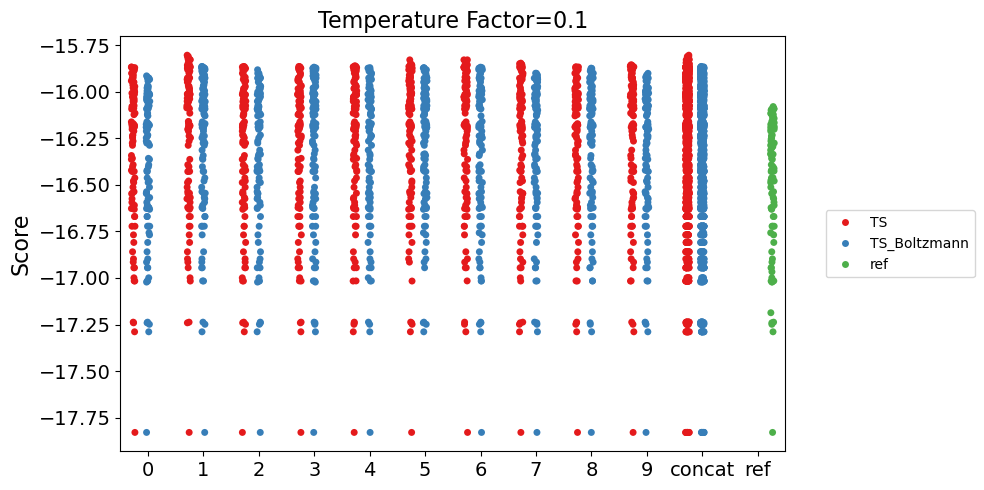

In [55]:
plt.figure(figsize=(10, 5))
palette_colors = sns.color_palette("Set1")[:3]
ax1 = sns.stripplot(data=combined_df, x="cycle", y="score", hue="method", dodge=True, palette=palette_colors)
ax1.set_ylabel("Score", fontsize=16)
ax1.set_xlabel("")
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))  # Pushes rightward
ax1.set_title("Temperature Factor=0.1", fontsize=16)

plt.tight_layout()  # Helps fit everything into the figure
plt.show()

We are able to change the temperature scaling coefficient, and then balance exploration and exploitation. The question becomes, if we can implement this in a more automated method. If we scale down the temperature then the algorithm becomes greedy and if we scale up the temperature then it becomes more explorative. 